In [ ]:
import glob2
import os
import cv2
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/'

/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition


In [ ]:
%ls

checkpoint_Adam/   Data/     Data224.zip  Data.zip           model/
checkpoint_NAdam/  Data2/    Data2.zip    hist.csv
checkpoint_SGD/    Data224/  DataTest/    MobileNetV2.ipynb


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/Data224.zip' -d '/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition'

In [ ]:
folder300 = '/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/Data'

In [ ]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/Data224'

In [ ]:
images_link = glob2.glob('/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/Data224/*/*.png')

In [ ]:
count = 0
for sub_folder in os.listdir(folder300):
  for image_file_name in os.listdir(os.path.join(folder300, sub_folder)):
    image = cv2.imread(os.path.join(folder300,sub_folder,image_file_name))
    image = cv2.resize(image,(224,224))
    cv2.imwrite(os.path.join(data_folder,sub_folder,image_file_name),image)
    count += 1
    print(count)

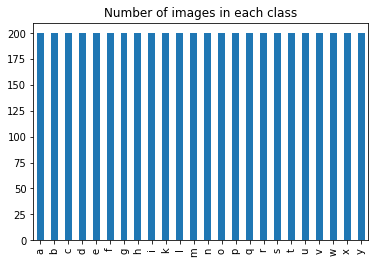

In [ ]:
data = pd.DataFrame({'labels': labels, 'image_links':images_link})
data.groupby(labels).image_links.count().plot.bar()
plt.title('Number of images in each class')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

images_train, images_val, y_label_train, y_label_val = train_test_split(images_link, labels, stratify = labels)

print('images_train len: {}, image_test shape: {}'.format(len(images_train), len(images_val)))


images_train len: 3600, image_test shape: 1200


In [ ]:
classNames = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']

In [ ]:
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/Data224',
    labels="inferred",
    label_mode="categorical",
    class_names=classNames,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=1337,
    validation_split= 0.2,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    smart_resize=False,
)

val_generator = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/Data224',
    labels="inferred",
    label_mode="categorical",
    class_names=classNames,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=1337,
    validation_split= 0.2,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    smart_resize=False,
)

Found 6000 files belonging to 24 classes.
Using 4800 files for training.
Found 6000 files belonging to 24 classes.
Using 1200 files for validation.


In [ ]:
base_network = MobileNetV2(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
flat = Flatten()
den = Dense(24, activation='softmax')

model = Sequential([base_network, 
                    flat,
                    den])
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.0001)
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 24)                1505304   
Total params: 3,763,288
Trainable params: 3,729,176
Non-trainable params: 34,112
_________________________________________________________________


#Checkpoint

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/checkpoint_SGD/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Frozen base_network
for layer in model.layers[:1]:
  layer.trainable = False

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))


Layer: <tensorflow.python.keras.engine.functional.Functional object at 0x7f16c00875d0> ; Trainable: False
Layer: <tensorflow.python.keras.layers.core.Flatten object at 0x7f16c8200a90> ; Trainable: True
Layer: <tensorflow.python.keras.layers.core.Dense object at 0x7f1680101810> ; Trainable: True


In [ ]:
model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          validation_data=val_generator,
          validation_steps=5,
          epochs=1, 
          callbacks=[model_checkpoint_callback])

150/150 [==============================] - 1291s 8s/step - loss: 2.5096 - accuracy: 0.3573 - val_loss: 3.3588 - val_accuracy: 0.1813


In [ ]:
# Frozen base_network
for layer in model.layers[:1]:
  layer.trainable = True

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

Layer: <tensorflow.python.keras.engine.functional.Functional object at 0x7f16c00875d0> ; Trainable: True
Layer: <tensorflow.python.keras.layers.core.Flatten object at 0x7f16c8200a90> ; Trainable: True
Layer: <tensorflow.python.keras.layers.core.Dense object at 0x7f1680101810> ; Trainable: True


In [ ]:
history = model.fit(train_generator,
          validation_data = val_generator,
          batch_size = 64,
          epochs = 100,
          callbacks=[model_checkpoint_callback])

Epoch 1/100
150/150 [==============================] - 251s 2s/step - loss: 0.9236 - accuracy: 0.7756 - val_loss: 2.7834 - val_accuracy: 0.2425
Epoch 2/100
150/150 [==============================] - 72s 476ms/step - loss: 0.5675 - accuracy: 0.8621 - val_loss: 2.2414 - val_accuracy: 0.3625
Epoch 3/100
150/150 [==============================] - 72s 475ms/step - loss: 0.4181 - accuracy: 0.8990 - val_loss: 1.7863 - val_accuracy: 0.4717
Epoch 4/100
150/150 [==============================] - 72s 478ms/step - loss: 0.3270 - accuracy: 0.9212 - val_loss: 1.4088 - val_accuracy: 0.5658
Epoch 5/100
150/150 [==============================] - 72s 477ms/step - loss: 0.2688 - accuracy: 0.9394 - val_loss: 1.0655 - val_accuracy: 0.6717
Epoch 6/100
150/150 [==============================] - 72s 475ms/step - loss: 0.2187 - accuracy: 0.9498 - val_loss: 0.8223 - val_accuracy: 0.7625
Epoch 7/100
150/150 [==============================] - 72s 478ms/step - loss: 0.1885 - accuracy: 0.9573 - val_loss: 0.6577 - v

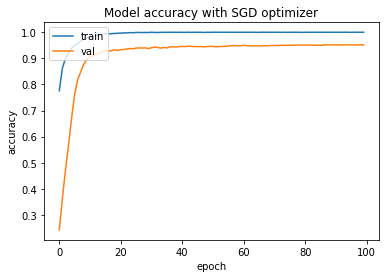

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy with SGD optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/model/hand_gesture_SGD.h5')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/model/hand_gesture_SGD.h5')

In [ ]:
model.load_weights(latest)

In [ ]:
y_pred = model.predict(val_generator)

In [ ]:
images = []
labels = []

In [ ]:
test_folder = '/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/DataTest'

In [ ]:
for sub_folder in os.listdir(test_folder):
    for image_file_name in os.listdir(os.path.join(test_folder, sub_folder)):
      image = cv2.imread(os.path.join(test_folder,sub_folder,image_file_name))
      images.append(image)
      labels.append(sub_folder)
      print(image_file_name)
      

In [ ]:
images = np.array(images,dtype=np.float32)
labels = np.array(labels)

In [ ]:
for i in range (len(images)):
  images[i] = np.reshape(images[i],[1,224,224,3])

In [ ]:
test_images, test_labels = shuffle(images, labels)

# Covert to tflite model


In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Colab Notebooks/Nhận dạng/Mobile Hand Gesture Recognition/model/model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
label = []
# for i in range (240):
input_data = images[0:1]
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = np.argmax(interpreter.get_tensor(output_details[0]['index']))
label.append(output_data)
print(output_data)


22


In [ ]:
classNames[output_data]

'x'

In [ ]:
test_images.shape

(240, 224, 224, 3)

In [ ]:
y_pred = model.predict_classes(test_images)

In [ ]:
y_pred

In [ ]:
y_result = []
for i in label:
  y_result.append(classNames[i])

In [ ]:
from sklearn.metrics import confusion_matrix

Confusion Matrix


array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 

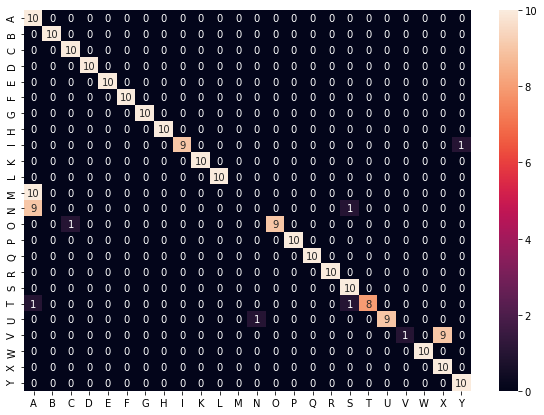

In [ ]:
import pandas as pd
import seaborn as sns
print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_result)
# plot_confusion_matrix(conf_mat=cm, figsize=(8, 8), show_normed=False)

df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHIKLMNOPQRSTUVWXY"],
                  columns = [i for i in "ABCDEFGHIKLMNOPQRSTUVWXY"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
confusion_matrix(test_labels, y_result)